In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
  #   for filename in filenames:
    #     print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## To display the graphs within the code and not in another windows 
import sys
print("Python Version :"+str(sys.version_info))
%matplotlib inline
# To be able to use CSV
import csv
print("CSV Version :"+csv.__version__)
# To be able to use Numpy
import numpy as np
print("Numpy Version :"+np.__version__)
# To be able to use Pandas
import pandas as pd
print("Pandas Version :"+pd.__version__)
# To be able to use Maplotlib
import matplotlib.pyplot as plt
import time
# To be able to use Seaborn
import seaborn as sns
print("Seaborn Version :"+sns.__version__)

import cv2 as cv
print("Open CV Version :"+cv.__version__)

from PIL import Image

# To be able to use Warning
import warnings
import os
import shutil
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import preprocess_input
from keras.applications import *
from keras.applications.xception import decode_predictions
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import *
from keras.layers.core import Dropout


import tensorflow as tf
print("Keras Version : "+tf.keras.__version__)
print("Tensorflow Version : "+tf.__version__)
# Install EfficientNet
!pip install efficientnet
import efficientnet.tfkeras as efn

Python Version :sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
CSV Version :1.0
Numpy Version :1.18.5
Pandas Version :1.1.0
Seaborn Version :0.10.0
Open CV Version :4.3.0
Keras Version : 2.4.0
Tensorflow Version : 2.3.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [17]:
images_directory = '/kaggle/input/mydogs/'
train_directory = '/kaggle/input/mydogs/train-small/'
test_directory = '/kaggle/input/mydogs/test-small/'
main_categories = [directory for directory in os.listdir(train_directory)]
main_categories.sort()
batch_size = 32

In [18]:
class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):
        """Constructor for mixup image data generator.
        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.
        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.
        Returns:
            int -- steps per epoch.
        """

        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.
        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [19]:
main_categories

['AfricanHuntingDog',
 'Basset',
 'BouvierDesFlandres',
 'Cardigan',
 'Dingo',
 'FrenchBulldog',
 'Kelpie',
 'Malinois',
 'OldEnglishSheepdog',
 'Redbone',
 'SaintBernard',
 'TibetanTerrier']

In [20]:
number_of_categories = len(main_categories)

# Split among the Train / Test / Validation images¶

In [21]:
# train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
transformation_ratio = .05
train_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=transformation_ratio, shear_range=transformation_ratio, zoom_range=transformation_ratio, cval=transformation_ratio, horizontal_flip=True, vertical_flip=True, validation_split=0.2)

# train_datagen = ImageDataGenerator(
  #  rescale=1/255,
  #  rotation_range=40,
  #  width_shift_range=0.2,
  #  height_shift_range=0.2,
  #  shear_range=0.2,
  #  zoom_range=0.2,
  #  horizontal_flip=True,
  #  validation_split=0.2
#)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [22]:
train_generator = train_datagen.flow_from_directory(train_directory, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', classes=main_categories, subset='training')

validation_generator = train_datagen.flow_from_directory(train_directory, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', classes=main_categories, subset='validation', shuffle=True)

Found 1110 images belonging to 12 classes.
Found 272 images belonging to 12 classes.


In [23]:
test_generator = test_datagen.flow_from_directory(test_directory, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', classes=main_categories, shuffle=False)

Found 578 images belonging to 12 classes.


# Definition of the model

In [24]:
 model = efn.EfficientNetB7(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [25]:

model.trainable = False

# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True
x = model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
# Ajouter la nouvelle couche fully-connected pour la classification 7 classes
predictions = Dense(number_of_categories, activation='softmax')(x)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)

In [26]:
print(new_model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

block6i_se_squeeze (GlobalAvera (None, 2304)         0           block6i_activation[0][0]         
__________________________________________________________________________________________________
block6i_se_reshape (Reshape)    (None, 1, 1, 2304)   0           block6i_se_squeeze[0][0]         
__________________________________________________________________________________________________
block6i_se_reduce (Conv2D)      (None, 1, 1, 96)     221280      block6i_se_reshape[0][0]         
__________________________________________________________________________________________________
block6i_se_expand (Conv2D)      (None, 1, 1, 2304)   223488      block6i_se_reduce[0][0]          
__________________________________________________________________________________________________
block6i_se_excite (Multiply)    (None, 7, 7, 2304)   0           block6i_activation[0][0]         
                                                                 block6i_se_expand[0][0]          
__________

Total params: 64,128,412
Trainable params: 26,274,476
Non-trainable params: 37,853,936
__________________________________________________________________________________________________
None


In [27]:
train_generator.reset()
validation_generator.reset()
# Compiler le modèle
# new_model.compile(loss="categorical_crossentropy", optimizer='nadam', metrics=["accuracy"])
# new_model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
# new_model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.9), metrics=["accuracy"])
new_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

In [28]:
earlystopping = EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 

In [29]:
start_time = time.time()

In [30]:
model_info = new_model.fit_generator(train_generator, validation_data=validation_generator, epochs=30, verbose=2, callbacks=[earlystopping])

Epoch 1/30
35/35 - 37s - loss: 2.3488 - accuracy: 0.2315 - val_loss: 1.8883 - val_accuracy: 0.6176
Epoch 2/30
35/35 - 26s - loss: 1.8848 - accuracy: 0.5027 - val_loss: 1.2852 - val_accuracy: 0.7500
Epoch 3/30
35/35 - 26s - loss: 1.3894 - accuracy: 0.6640 - val_loss: 0.8715 - val_accuracy: 0.8162
Epoch 4/30
35/35 - 26s - loss: 1.0913 - accuracy: 0.7189 - val_loss: 0.6933 - val_accuracy: 0.8162
Epoch 5/30
35/35 - 26s - loss: 0.8487 - accuracy: 0.7910 - val_loss: 0.5483 - val_accuracy: 0.8382
Epoch 6/30
35/35 - 27s - loss: 0.7284 - accuracy: 0.8180 - val_loss: 0.5252 - val_accuracy: 0.8493
Epoch 7/30
35/35 - 25s - loss: 0.6381 - accuracy: 0.8225 - val_loss: 0.5085 - val_accuracy: 0.8346
Epoch 8/30
35/35 - 27s - loss: 0.5364 - accuracy: 0.8459 - val_loss: 0.4902 - val_accuracy: 0.8566
Epoch 9/30
35/35 - 25s - loss: 0.4857 - accuracy: 0.8730 - val_loss: 0.4413 - val_accuracy: 0.8750
Epoch 10/30
35/35 - 26s - loss: 0.4135 - accuracy: 0.8901 - val_loss: 0.4686 - val_accuracy: 0.8419
Epoch 11/

In [31]:
print("Time:"+ (str)(time.time()-start_time))

Time:623.288562297821


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


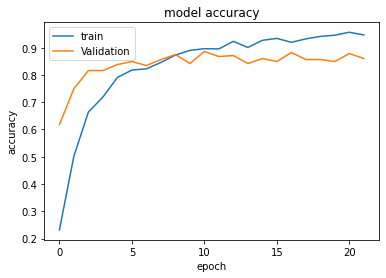

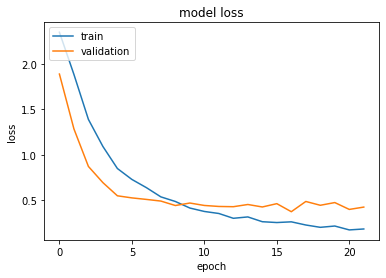

In [32]:
# list all data in history
print(model_info.history.keys())
# summarize history for accuracy
plt.plot(model_info.history['accuracy'])
plt.plot(model_info.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
test_generator.reset()
score = new_model.evaluate_generator(test_generator, (test_generator.samples + (batch_size-1)) // batch_size)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

For test data set; Loss:  0.2217261791229248  Accuracy:  0.9411764740943909


In [34]:
test_generator.reset()

testStep = (test_generator.samples + (batch_size-1)) // batch_size
print("testStep: ", testStep)

testStep:  19


In [35]:
Y_pred = new_model.predict_generator(test_generator, steps=testStep, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
print(str(len(y_pred)))
labels = (validation_generator.class_indices)
print("Labels "+(str)(labels))
labels = dict((v, k) for k, v in labels.items())
print(labels)
predictedLabels = [labels[k] for k in y_pred]
#print("Predicted Labels "+(str)(predictedLabels))
len(predictedLabels)
actualLabels = [labels[k] for k in test_generator.classes]
print("Actual Labels "+(str)(actualLabels))
len(actualLabels)

19/19 - 4s
[ 0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
  0  0  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  9  1  1  1  1  1
  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2 11  2  2  2  2 11  2 11 11  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  3  3  3  3  3  3  3  3  3  3  1  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  1
  4  4  0  7  4  3  4  4  4  6  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5
  5  5  5  5  3 10  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  3  5  5  5  6  5  5  5  5  5  6  6  6
  6  6  6  6  6  6  6  6  6  3  7  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  3  3  4  6 

578

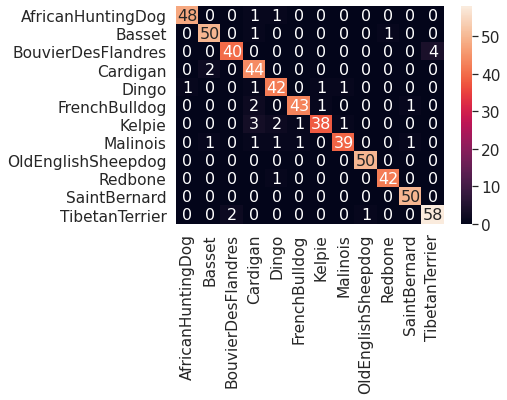

In [36]:
df_cm = pd.DataFrame(confusion_matrix(actualLabels, predictedLabels), main_categories, main_categories)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [37]:
print(classification_report(actualLabels, predictedLabels))

                    precision    recall  f1-score   support

 AfricanHuntingDog       0.98      0.96      0.97        50
            Basset       0.94      0.96      0.95        52
BouvierDesFlandres       0.95      0.91      0.93        44
          Cardigan       0.83      0.96      0.89        46
             Dingo       0.89      0.91      0.90        46
     FrenchBulldog       0.96      0.91      0.93        47
            Kelpie       0.95      0.84      0.89        45
          Malinois       0.95      0.89      0.92        44
OldEnglishSheepdog       0.98      1.00      0.99        50
           Redbone       0.98      0.98      0.98        43
      SaintBernard       0.96      1.00      0.98        50
    TibetanTerrier       0.94      0.95      0.94        61

          accuracy                           0.94       578
         macro avg       0.94      0.94      0.94       578
      weighted avg       0.94      0.94      0.94       578

